# Create Kerchunk Reference Files from ARISE Data on AWS

## Imports

In [3]:
import fsspec
from kerchunk.hdf import SingleHdf5ToZarr
from kerchunk.combine import MultiZarrToZarr
from distributed import Client, LocalCluster
import dask
import ujson 
import nc_time_axis
import glob
import xarray as xr

## Spin up a Cluster
Let's spin up a Dask Cluster on our local machine! This will help compute our reference files in parallel.

In [2]:
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51042,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:51061,Total threads: 3
Dashboard: http://127.0.0.1:51064/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:51046,


## Create our Reference Files
This is a process you will only need to do once for each file on Amazon S3

In [19]:
fs = fsspec.filesystem('s3',
                       skip_instance_cache=True)

### Setup our AWS Credentials - **Do This Before Running this Section**

We need to set which bucket to use -  before running this notebook or running throught this analysis, make sure to setup your credentials (email Brian Dobbins from NCAR if you need the credentials) using the [AWS Command Line Interface (CLI)](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html).

Once you install the CLI, go to the command line and run:

```bash
aws configure
```

Which will prompt you for the credentials.

### List Files on the Bucket

In [20]:
bucket = 'sl-ncar-test-bucket'

In [ ]:
files = fs.glob(f's3://sl-ncar-test-bucket/proc/tseries/month_1/*')

We need to add the `s3://` portion in front of each of these paths since they are on AWS

In [27]:
urls = ["s3://" + f for f in files]

so = dict(mode='rb', anon=True, default_fill_cache=False, default_cache_type='first')

### Setup a Function to Generate our Reference Files

In [28]:
def gen_json(u):
    with fs.open(u, **so) as infile:
        h5chunks = SingleHdf5ToZarr(infile, u, inline_threshold=300)
        outf = f"jsons/{u.split('/')[-1]}.json"
        print(outf)
        with open(outf, 'wb') as f:
            f.write(ujson.dumps(h5chunks.translate()).encode());

Now that we have our function to operate on each file, let's compute this in parallel using dask

In [ ]:
%%time
dask.compute(*[dask.delayed(gen_json)(u) for u in urls], retries=10);

## Read back in the jsons (**Start here if you already have the reference files**)
Let's start by listing all the jsons we wish to combine into a single dataset (by default, let's combine all the variables)

Let' just start with the last 10 variables.

In [34]:
furls = sorted(glob.glob('jsons/*'))[-10:]

Now that we have all of our reference files, we can combine them into a single Zarr dataset

In [35]:
mzz = MultiZarrToZarr(
    furls,
    remote_protocol="s3",
    concat_dims=["time"]
)

# Combine the zarr file into something we can read into xarray
out = mzz.translate()

### Load the dataset into an xarray dataset
Now that we have our kerchunk zarr reference dataset, we can read this into xarray!

In [36]:
ds = xr.open_dataset(
    "reference://",
    engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo": out,
            "remote_protocol": "s3",
        },
        "consolidated": False
    },
    chunks={}
)

Let's look at our dataset!

In [37]:
ds

<xarray.Dataset>
Dimensions:                  (time: 12, lat: 192, ilev: 71, lev: 70, lon: 288,
                              nbnd: 2, zlon: 1)
Coordinates:
  * ilev                     (ilev) float64 4.5e-06 7.42e-06 ... 985.1 1e+03
  * lat                      (lat) float64 -90.0 -89.06 -88.12 ... 89.06 90.0
  * lev                      (lev) float64 5.96e-06 9.827e-06 ... 976.3 992.6
  * lon                      (lon) float64 0.0 1.25 2.5 ... 356.2 357.5 358.8
  * time                     (time) object 2035-02-01 00:00:00 ... 2036-01-01...
  * zlon                     (zlon) float64 0.0
Dimensions without coordinates: nbnd
Data variables: (12/36)
    P0                       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ch4vmr                   (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    co2vmr                   (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    date                     (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    date_written             (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    datesec                  (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    ...                       ...
    sol_tsi                  (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    time_bnds                (time, nbnd) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_written             (time) object dask.array<chunksize=(1,), meta=np.ndarray>
    wet_deposition_NHx_as_N  (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    wet_deposition_NOy_as_N  (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    zlon_bnds                (time, zlon, nbnd) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    case:              b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-LOWER-0.5.001
    host:               
    initial_file:      b.e21.BWSSP245cmip6.f09_g17.CMIP6-SSP2-4.5-WACCM.001.c...
    logname:           geostrat
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    source:            CAM
    time_period_freq:  month_1
    topography_file:   /scratch/geostrat/inputdata/atm/cam/topo/fv_0.9x1.25_n...

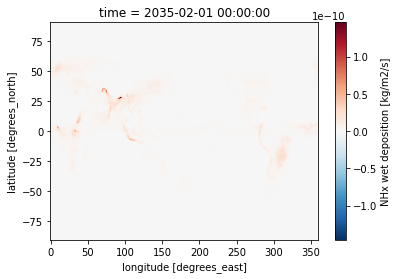

In [41]:
ds.wet_deposition_NHx_as_N.isel(time=0).plot();